In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/minerals-identification-dataset/minet/quartz/0106.jpg
/kaggle/input/minerals-identification-dataset/minet/quartz/0074.jpg
/kaggle/input/minerals-identification-dataset/minet/quartz/0077.jpg
/kaggle/input/minerals-identification-dataset/minet/quartz/0058.jpg
/kaggle/input/minerals-identification-dataset/minet/quartz/0128.jpg
/kaggle/input/minerals-identification-dataset/minet/quartz/0141.jpg
/kaggle/input/minerals-identification-dataset/minet/quartz/0053.jpg
/kaggle/input/minerals-identification-dataset/minet/quartz/0006.jpg
/kaggle/input/minerals-identification-dataset/minet/quartz/0095.jpg
/kaggle/input/minerals-identification-dataset/minet/quartz/0070.jpg
/kaggle/input/minerals-identification-dataset/minet/quartz/0092.jpg
/kaggle/input/minerals-identification-dataset/minet/quartz/0057.jpg
/kaggle/input/minerals-identification-dataset/minet/quartz/0044.jpg
/kaggle/input/minerals-identification-dataset/minet/quartz/0078.jpg
/kaggle/input/minerals-identification-dataset/mi

['quartz', 'malachite', 'chrysocolla', 'pyrite', 'muscovite', 'biotite', 'bornite']
(837, 128, 128, 3)
Accuracy =  0.5591397849462365


/opt/conda/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


The prediction for this image is:  ['malachite']
The actual label for this image is:  malachite


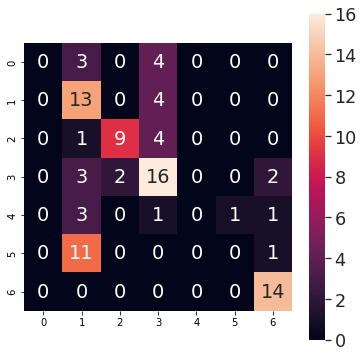

In [2]:


import numpy as np
import matplotlib.pyplot as plt
import glob
import cv2
import os
import seaborn as sns
import pandas as pd
from skimage.filters import sobel
from scipy import ndimage as nd

from skimage.filters.rank import entropy 
from skimage.morphology import disk


from sklearn.model_selection import train_test_split

#Store images and labels as numpy array 
SIZE = 128
images = []
labels = []


data = "../input/minerals-identification-dataset/minet/"

folders = os.listdir(data)

print(folders)


# image_names = []
# train_labels = []
# train_images = []

# size = 150,150

for folder in folders:
    for file in os.listdir(os.path.join(data,folder)):
        if file.endswith("jpg"):
            
            
            
            img = cv2.imread(os.path.join(data,folder,file), cv2.IMREAD_COLOR)
            img = cv2.resize(img, (SIZE, SIZE))
            images.append(img)
            labels.append(folder)
        else:
            continue

            

        
        
images = np.array(images)
labels = np.array(labels)

# test_images = []
# test_labels = []

# for dir_path in glob.glob("/content/drive/MyDrive/mineral classification/minet2/test/*"):
#     label = dir_path.split("\\")[-1]
#     print(label)
#     for img_path in glob.glob(os.path.join(dir_path, "*.jpg")):
#         print(img_path)
#         img = cv2.imread(img_path, cv2.IMREAD_COLOR)
#         img = cv2.resize(img, (SIZE, SIZE))
#         test_images.append(img)
#         test_labels.append(label)
        
# test_images = np.array(test_images)
# test_labels = np.array(test_labels)

#Encoding labels
from sklearn import preprocessing
lab_enc = preprocessing.LabelEncoder()
lab_enc.fit(labels)
labels_encoded = lab_enc.transform(labels)
# lab_enc.fit(test_labels)
# test_labels_encoded = lab_enc.transform(test_labels)



x_train, x_test, y_train, y_test = train_test_split(images, labels_encoded, test_size=0.1, random_state=42)


x_train = np.array(x_train)
x_test = np.array(x_test)
y_train = np.array(y_train)
y_test = np.array(y_test)



#Normalising pixel values to 0-1
x_train = x_train/255.0
x_test = x_test/255.0

print(x_train.shape)

#Feature Extraction
# FEATURE EXTRACTOR function
# input shape is (n, x, y, c) - number of images, x, y, and channels
def feature_extractor(dataset):
    image_dataset = pd.DataFrame()
    for image in range(dataset.shape[0]):  #iterate through each file 
        #print(image)
        
        df = pd.DataFrame()  #Temporary data frame to capture information for each loop.
        #Reset dataframe to blank after each loop.
        
        input_img = dataset[image, :,:,:]
        img = input_img
    ################################################################
    #START ADDING DATA TO THE DATAFRAME
    #Add feature extractors, e.g. edge detection, smoothing, etc. 
            
         # FEATURE 1 - Pixel values
         
        #Add pixel values to the data frame
        pixel_values = img.reshape(-1)
        df['Pixel_Value'] = pixel_values   #Pixel value itself as a feature
        #df['Image_Name'] = image   #Capture image name as we read multiple images
        
        # FEATURE 2 - Bunch of Gabor filter responses
        
                #Generate Gabor features
        num = 1  #To count numbers up in order to give Gabor features a lable in the data frame
        kernels = []
        for theta in range(2):   #Define number of thetas
            theta = theta / 4. * np.pi
            for sigma in (1, 3):  #Sigma with 1 and 3
                lamda = np.pi/4
                gamma = 0.5
                gabor_label = 'Gabor' + str(num)  #Label Gabor columns as Gabor1, Gabor2, etc.
    #                #print(gabor_label)
                ksize=9
                kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lamda, gamma, 0, ktype=cv2.CV_32F)    
                kernels.append(kernel)
                #Now filter the image and add values to a new column 
                fimg = cv2.filter2D(img, cv2.CV_8UC3, kernel)
                filtered_img = fimg.reshape(-1)
                df[gabor_label] = filtered_img  #Labels columns as Gabor1, Gabor2, etc.
                #print(gabor_label, ': theta=', theta, ': sigma=', sigma, ': lamda=', lamda, ': gamma=', gamma)
                num += 1  #Increment for gabor column label
                
         
       # FEATURE 3 Sobel
        edge_sobel = sobel(img)
        edge_sobel1 = edge_sobel.reshape(-1)
        df['Sobel'] = edge_sobel1
       
       # FEATURE 4 Gaussian
        gaussian_fil = nd.gaussian_filter(img, sigma = 2)
        gaussian_fil = gaussian_fil.reshape(-1)
        df['Gaussian'] = gaussian_fil

      #  # FEATURE ENTROPY
      #   entropy_img = entropy(img, disk(1))
      #   df['Entropy'] = entropy_img
      #   #Add more filters as needed
        
        #Append features from current image to the dataset
        image_dataset = image_dataset.append(df)
        
    return image_dataset
####################################################################
#Extract features from training images
image_features = feature_extractor(x_train)


image_features.head()

#Defining a model

#Reshape to a vector for Random Forest / SVM training
n_features = image_features.shape[1]
image_features = np.expand_dims(image_features, axis=0)
X_for_RF = np.reshape(image_features, (x_train.shape[0], -1))  #Reshape to #images, features

# #Define the classifier
# from sklearn.ensemble import RandomForestClassifier
# RF_model = RandomForestClassifier(n_estimators = 50, random_state = 42)

#Can also use SVM but RF is faster and may be more accurate.
from sklearn import svm
SVM_model = svm.SVC(decision_function_shape='ovo')  #For multiclass classification
SVM_model.fit(X_for_RF, y_train)



#Model prediction

#Predict on Test data
#Extract features from test data and reshape, just like training data
test_features = feature_extractor(x_test)
test_features = np.expand_dims(test_features, axis=0)
test_for_SVM = np.reshape(test_features, (x_test.shape[0], -1))

#Predict on test
test_prediction = SVM_model.predict(test_for_SVM)





test_prediction = lab_enc.inverse_transform(test_prediction)
y_test  = lab_enc.inverse_transform(y_test )



#Print overall accuracy
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(y_test, test_prediction))

#Print confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, test_prediction)

fig, ax = plt.subplots(figsize=(6,6))         # Sample figsize in inches
sns.set(font_scale=1.6)
sns.heatmap(cm, annot=True, ax=ax)

#Check results on a few random images
import random
n=random.randint(0, x_test.shape[0]-1) #Select the index of image to be loaded for testing
img = x_test[n]
plt.imshow(img)

#Extract features and reshape to right dimensions
input_img = np.expand_dims(img, axis=0) #Expand dims so the input is (num images, x, y, c)
input_img_features=feature_extractor(input_img)
input_img_features = np.expand_dims(input_img_features, axis=0)
input_img_for_SVM = np.reshape(input_img_features, (input_img.shape[0], -1))
#Predict
img_prediction = SVM_model.predict(input_img_for_SVM)
img_prediction = lab_enc.inverse_transform([img_prediction])  #Reverse the label encoder to original name
print("The prediction for this image is: ", img_prediction)
print("The actual label for this image is: ", y_test[n])





# #Model fitting a
# # Fit the model on training data
# SVM_model.fit(X_for_RF, y_train) #For sklearn no one hot encoding